In [5]:
# import dependencies 
from fastai.vision.all import *
import timm
from torchvision.datasets import MNIST
from torchvision import transforms

In [6]:
def create_dls(train_pct):
    dls = ImageDataLoaders.from_folder(
    'PlantDoc',
    train_pct=train_pct, 
    valid_pct=0.2, 
    seed=42,
    item_tfms=Resize(12),
    )
    return dls

In [7]:
def get_mean_table(results_table):
    # 1 & 2: Group by 'train_pct' and calculate the mean of 'acc'
    grouped = results_table.groupby('train_pct')['acc'].mean().reset_index()
    # 3: Create the new DataFrame
    mean_table = grouped.rename(columns={'acc': 'mean_acc'})
    return mean_table

In [8]:
train_pcts = [0.05, 0.1, 0.25, 0.5]
replicates = 3
results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct)
    create_dls(train_pct)
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=1)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        results_table = pd.concat([results_table, row])

mean_table = get_mean_table(results_table)

Creating DL: 0.05


e:\Users\Dalton\anaconda3\envs\plant_inspector\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


0.05 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,5.447093,4.381891,0.058824,01:35


epoch,train_loss,valid_loss,accuracy,time
0,3.747109,3.732311,0.080392,01:36


C:\Users\Dalton\AppData\Local\Temp\ipykernel_19912\151175362.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, row])


0.05 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,5.441333,5.195150,0.047059,01:32


epoch,train_loss,valid_loss,accuracy,time
0,3.821294,3.768426,0.078431,01:34


0.05 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,5.420305,5.170282,0.070588,01:34


epoch,train_loss,valid_loss,accuracy,time
0,3.707866,3.966054,0.064706,01:36


Creating DL: 0.1
0.1 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,5.484655,5.293856,0.072549,01:32


epoch,train_loss,valid_loss,accuracy,time
0,3.711582,3.774353,0.070588,01:35


0.1 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,5.472100,4.160757,0.066667,01:31


epoch,train_loss,valid_loss,accuracy,time
0,3.765307,3.565819,0.068627,01:31


0.1 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,5.544377,4.394250,0.056863,01:36


epoch,train_loss,valid_loss,accuracy,time
0,3.738528,3.675426,0.070588,01:32


Creating DL: 0.25
0.25 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,5.443054,4.666153,0.041176,01:34


epoch,train_loss,valid_loss,accuracy,time
0,3.658373,3.713011,0.074510,01:37


0.25 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,5.506457,4.798714,0.054902,01:32


epoch,train_loss,valid_loss,accuracy,time
0,3.681783,3.607226,0.086275,01:28


0.25 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,5.606513,4.334060,0.062745,01:29


epoch,train_loss,valid_loss,accuracy,time
0,3.735537,3.767626,0.072549,01:29


Creating DL: 0.5
0.5 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,5.521424,4.978007,0.064706,01:33


epoch,train_loss,valid_loss,accuracy,time
0,3.784798,3.711720,0.082353,01:33


0.5 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,5.558537,6.399454,0.047059,01:29


epoch,train_loss,valid_loss,accuracy,time
0,3.743834,3.668402,0.064706,01:36


0.5 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,5.427204,4.167554,0.066667,01:34


epoch,train_loss,valid_loss,accuracy,time
0,3.710316,3.554178,0.066667,01:31


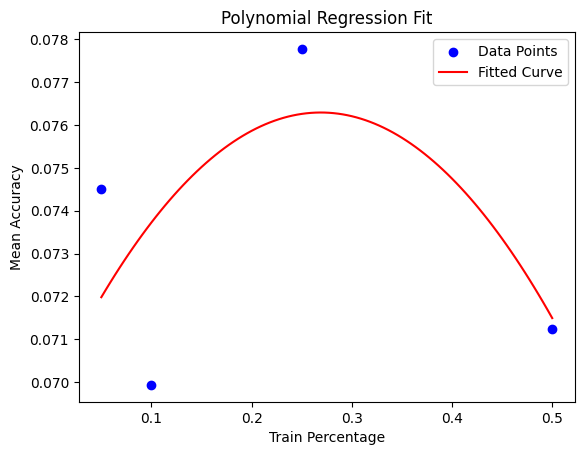

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'mean_df' is your DataFrame with 'train_pct' and 'mean_acc'
x = mean_table['train_pct']
y = mean_table['mean_acc']

# Choose the degree of the polynomial (e.g., 2 for quadratic)
degree = 2

# Fit the polynomial regression model
coefficients = np.polyfit(x, y, degree)

# Use the fitted model to predict values
polynomial = np.poly1d(coefficients)
x_line = np.linspace(min(x), max(x), 100)
y_line = polynomial(x_line)

# Plotting the original data points
plt.scatter(x, y, color='blue', label='Data Points')

# Plotting the fitted curve
plt.plot(x_line, y_line, color='red', label='Fitted Curve')

plt.xlabel('Train Percentage')
plt.ylabel('Mean Accuracy')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.show()


In [10]:
from scipy.optimize import fsolve

# Set your target accuracy
target_accuracy = 0.99  # Adjust this as needed

# Define the function to find roots
# This function represents the polynomial equation - target_accuracy = 0
def equation(train_pct):
    return polynomial(train_pct) - target_accuracy

# Initial guess for train_pct - it's important to choose a reasonable starting point
initial_guess = 0.5

# Solving the equation
predicted_train_pct = fsolve(equation, initial_guess)

print(f"Predicted train_pct for achieving {target_accuracy} accuracy: {predicted_train_pct[0]}")


Predicted train_pct for achieving 0.99 accuracy: 0.26865319789139147


e:\Users\Dalton\anaconda3\envs\plant_inspector\lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Prepare the data
X = mean_table[['mean_acc']]  # Independent variable
y = mean_table['train_pct']  # Dependent variable

# We can use a polynomial regression model
# Choose a degree for polynomial features
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Train the model
model = LinearRegression()
model.fit(X_poly, y)

# Predict the required train_pct for a given accuracy
desired_accuracy = 0.42
predicted_train_pct = model.predict(poly.transform([[desired_accuracy]]))

print(f"Predicted train_pct for achieving {desired_accuracy} accuracy: {predicted_train_pct[0]}")


Predicted train_pct for achieving 0.42 accuracy: 204.95266060008646


e:\Users\Dalton\anaconda3\envs\plant_inspector\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [12]:
# Resnet-18
# epoch	train_loss	valid_loss	accuracy	time
# 0	2.329669	2.175517	0.398039	04:44
# 1	2.047739	1.710715	0.527451	04:47
# 2	1.696105	1.822478	0.431373	04:57
# 3	1.373082	1.125379	0.621569	05:14
# 4	1.118939	1.178962	0.613725	05:16
# 5	0.903016	1.063396	0.656863	05:16
# 6	0.726309	0.970530	0.662745	05:16
# 7	0.587566	0.937186	0.670588	05:15
# 8	0.492905	0.925825	0.688235	05:04
# 9	0.435941	0.922592	0.692157	04:56

In [13]:
learn.save('fine_tuned_model')

Path('PlantDoc/models/fine_tuned_model.pth')